# Detecting misfitting items in Rasch models

Magnus Johansson [](https://orcid.org/0000-0003-1669-592X) ([RISE Research Institutes of Sweden](https://ri.se/shic))  
January 2, 2025

Psychometrics in general have long relied on rule-of-thumb cutoff values for various goodness of fit metrics. With more powerful personal computers it is both feasible and desirable to use simulation/bootstrap methods to determine appropriate cutoff values. This paper illustrates and evaluates the use of an R package for Rasch psychometrics that has implemented functions to simplify the process of identifying misfitting items using simulation based cutoff values. Through a series of simulation studies a comparison is made between information weighted conditional item fit and item-restscore using Goodman and Kruskal’s gamma.

# Introduction

This paper presents a series of simulations conducted to evaluate methods to detect of item misfit in Rasch models. First, conditional item infit and outfit will be under scrutiny. Second, item infit will be compared to item-restscore \[@kreiner_note_2011;@mueller_iarm_2022\]. Third, a bootstrap method for item-restscore will be presented and tested.

Müller \[-@muller_item_2020\] showed how the range of conditional item infit varies with sample size and the expected average item infit range is fairly well captured by Smith’s rule-of-thumb formula (1±2/√n). However, the average range does not apply for all items, since item location also affects model expected item fit which means some items may have plausible item fit values outside Smith’s average value range.

It is proposed that by using parametric bootstrapping one can establish item fit cutoff values that are sample and item specific. The R package `easyRasch` \[@easyrasch\] includes a function to determine item infit and outfit cutoff values, which will be tested in the simulations in this paper.

It is important to note that the conditional item fit described by Müller \[-@muller_item_2020\] and implemented in the `iarm` R package \[@mueller_iarm_2022\] is different from the unconditional item fit implemented in software such as Winsteps and RUMM2030, as well as all R packages except `iarm`. Unconditional item fit can result in unreliable item fit in sample sizes as small as 250 with increasing likelihood of problems as sample size increases. Readers are strongly recommended to read Müller’s paper to fully understand the problems with unconditional item fit.

# Methods

In [ ]:
library(iarm)

Loading required package: eRm

Loading required package: ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: formattable
Loading required package: kableExtra

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

Loading required package: mirt
Loading required package: stats4
Loading required package: lattice

Attaching package: 'mirt'

The following objects are masked from 'package:eRm':

    itemfit, personfit

Loading required package: psych

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'package:eRm':

    sim.rasch

Loading required package: psychotree
Loading required package: partykit
Loading required package: grid
Loading required package: libcoin
Loading required package: mvtnorm
Loading required package: psychotools
Loading required package: matrixStats

Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count

Loading required package: reshape

Attaching package: 'reshape'

The

Some features are not enabled in this build of Arrow. Run `arrow_info()` for more information.
The repository you retrieved Arrow from did not include all of Arrow's features.
You can install a fully-featured version by running:
`install.packages('arrow', repos = 'https://apache.r-universe.dev')`.

Attaching package: 'arrow'

The following object is masked from 'package:lubridate':

    duration

The following object is masked from 'package:utils':

    timestamp

Loading required package: sysfonts
Loading required package: showtextdb

The simulation of response data used three steps: first, a vector of theta values (person scores on the latent variable) were generated using `rnorm(mean = 0, sd = 1.5)`. Second, a set of item locations ranging from -2 to 2 logits were generated for dichotomous items, using `runif(n = 20, min = -2, max = 2)`. Third, the theta values were used to simulate item responses for participants, using `sim.xdim()` from the `eRm` package \[@mair_extended_2007\], which allows simulation of multidimensional response data. Multiple datasets were generated using the same item and person parameters, varying the targeting and number of the misfitting item(s). More details are described under the separate studies below.

The parametric bootstrapping procedure was implemented using random samples from the 10 000 simulated responses. The sample size variations tested are described under each study.

1.  Estimation of item locations based on simulated item responses using conditional maximum likelihood \[CML, @mair_extended_2007\].
2.  Estimation of sample theta values using weighted maximum likelihood \[@warm_weighted_1989\]
3.  Simulation of new response data, fitting the Rasch model, using the estimated item locations and theta values.
4.  Estimation of the dichotomous Rasch model for the new response data using CML.
5.  Based on step 4, calculation of conditional item fit \[@muller_item_2020;@mueller_iarm_2022\] and/or item-restscore metrics \[@kreiner_note_2011;@mueller_iarm_2022\].

Steps three and four were iterated over, using resampling with replacement from the estimated theta values as a basis for simulating the response data in step three.

Summary statistics were created with focus on correctly detecting misfit and whether false positives were identified.

In [ ]:
# read pre-generated item locations for reproducibility
items1 <- read_csv("data/rm_items40.csv") %>%
  slice(1:20) %>% 
  pull(location)

Rows: 40 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): item, location

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# a matrix to specify which dimension each item loads on
wmat0 <- matrix(nrow = 20,
               ncol = 2)
# set all items to load on dimension one
wmat0[1:20,1] <- 1
wmat0[1:20,2] <- 0
# item 9, with good targeting in this item set (closest to sample theta mean of 0), is chosen to belong to a second dimension
wmat0[9,1] <- 0
wmat0[9,2] <- 1

# a matrix to specify which dimension each item loads on
wmat1 <- matrix(nrow = 20,
               ncol = 2)
wmat1[1:20,1] <- 1
wmat1[1:20,2] <- 0
wmat1[18,1] <- 0
wmat1[18,2] <- 1

# a matrix to specify which dimension each item loads on
wmat2 <- matrix(nrow = 20,
               ncol = 2)
wmat2[1:20,1] <- 1
wmat2[1:20,2] <- 0
wmat2[13,1] <- 0
wmat2[13,2] <- 1

# generate dichotomous data
simdata0 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat0)
simdata1 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat1)
simdata2 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat2)

simdata <- list(data0 = simdata0,
                data1 = simdata1,
                data2 = simdata2)
#saveRDS(simdata,"simdata10000.rds")

In [ ]:
simdata <- readRDS("data/simdata10000.rds")
demodata <- simdata[[1]] %>% 
  as.data.frame() %>% 
  slice(1:400) %>% 
  select(V1,V11,V3,V12)

# Study 1

Conditional mean square (MSQ) infit and outfit, henceforth referred to only as infit or outfit. **Refer to Müller (and vignette ref) for technical description…**

Main lines of inquiry:

1.  How does the number of iterations used in RIgetfit() impact the indicated cutoff values?
2.  How useful are the cutoff values in detecting misfitting items (and false positives), when using the optimal number of iterations?
3.  Müller \[-@muller_item_2020\] hints at outfit being less useful than infit. We will investigate this by comparing them.

20 dichotomous items are used, with one item misfitting. Item locations are the same throughout. The location of the misfitting item relative the to the sample theta mean was selected to be approximately 0, -1, and -2 logits. Three separate datasets were generated with these variations, each with 10 000 simulated respondents. One dataset with all three misfitting items was also generated, using the same sample size.

The function `RIgetfit()` from the `easyRasch` R package is tested here. It’s source code can be accessed on GitHub. The function offers the user a choice of the number of bootstrap iterations to use to calculate the cutoff values for infit and outfit.

Then the `RIitemfit()` function is used to summarize the bootstrap results and also calculates the infit and outfit for each item in the observed data and highlights items with infit/outfit values outside of the cutoff values. `RIitemfit()` has a default setting to slightly truncate the distribution of values using `stats::quantile()` at 0.001 and 0.999 to reduce extreme values. An example is demonstrated in @tbl-itemfit1, using a subset of the items used in the simulations. @fig-itemfit1 provides a visualization of the distribution of bootstrapped infit and outfit values, together with the infit/outfit values from the observed data illustrated using an orange diamond shape. Note the variation between items in plausible values of infit and outfit based on the bootstrap, and that Smith’s rule-of-thumb regarding infit (1±2/√n) would be 0.9-1.1 for a sample size of 400.

This study was rather computationally demanding since each simulation run entailed 100-400 underlying simulations. The sample sizes used were 150, 250, 500, and 1000. The number of iterations to determine cutoff values were 100, 200, and 400. Sample size and iteration conditions were fully crossed with each other and the three different targeting variations of the one misfitting item, resulting in 4*3*3 = 36 conditions. Each combination used 200 simulation runs. The simulations took about 12 hours to run on a Macbook Pro Max M1 using 9 CPU cores.

In [ ]:
simfit <- RIgetfit(demodata, iterations = 400, cpu = 8)
RIitemfit(demodata, simfit, output = "quarto")

  ----------------------------------------------------------------------------------------
  Item     InfitMSQ Infit           OutfitMSQ Outfit         Infit    Outfit      Location
                    thresholds                thresholds     diff     diff      
  ------ ---------- ------------- ----------- -------------- -------- --------- ----------
  V1          1.017 \[0.823,            1.061 \[0.603,       no       no misfit      -1.37
                    1.146\]                   1.486\]        misfit             

  V11         1.000 \[0.82,             1.032 \[0.698,       no       no misfit      -0.66
                    1.211\]                   1.422\]        misfit             

  V3          1.022 \[0.896,            1.050 \[0.638,       no       no misfit       0.46
                    1.086\]                   1.423\]        misfit             

  V12         0.966 \[0.827,            0.793 \[0.804,       no       0.011           1.58
                    1.206\]                   1.274\]        misfit             
  ----------------------------------------------------------------------------------------


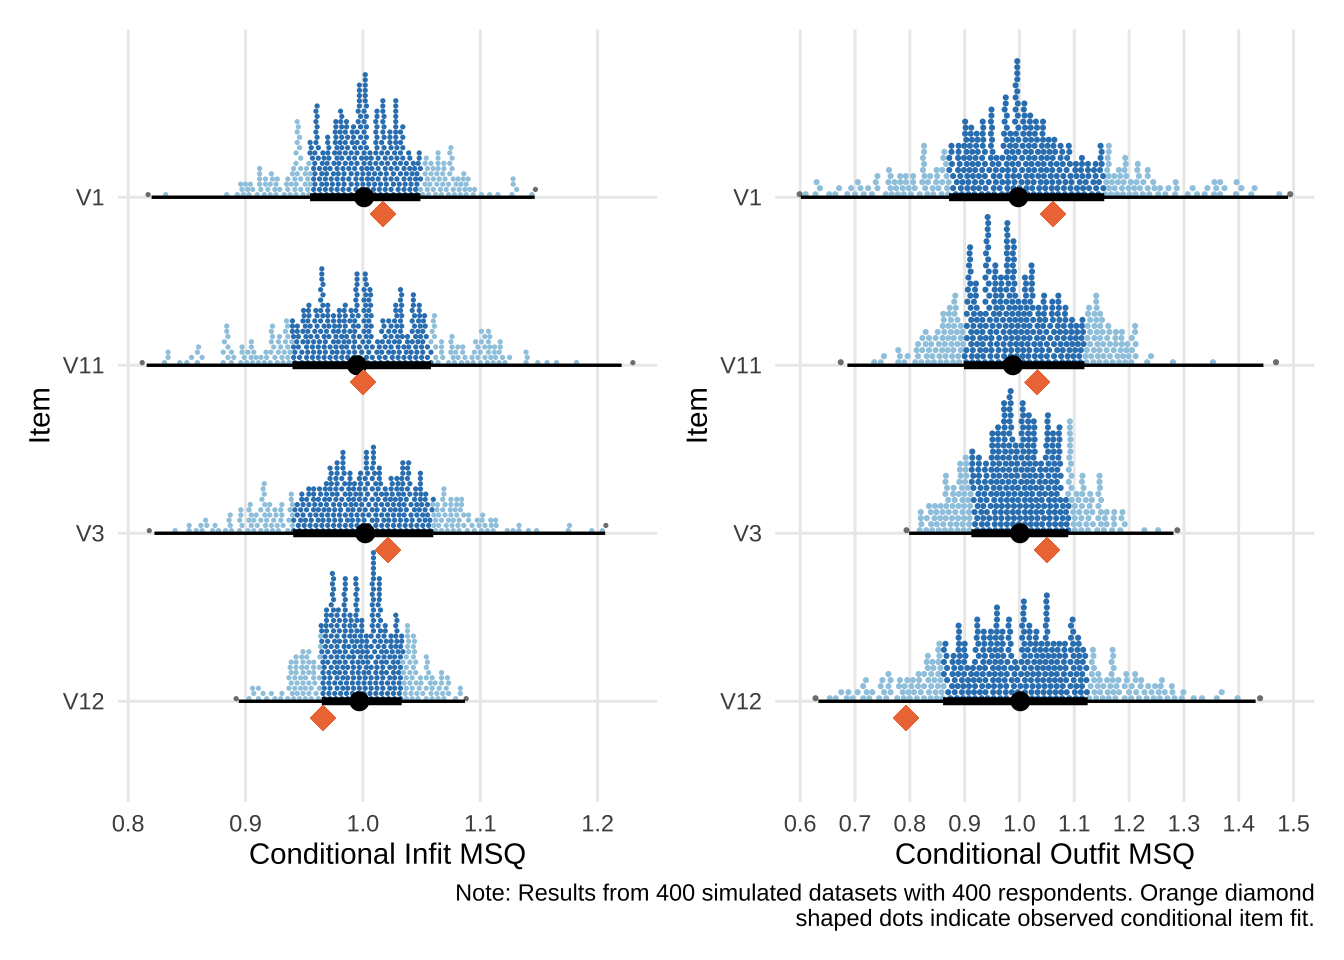

In [ ]:
RIgetfitPlot(simfit, demodata)

In [ ]:
# define function to run simulations for item infit/outfit cutoff values
itemfitboot <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    # get simulation based cutoff values
    sfit100 <- RIgetfit(data,100,9)
    sfit200 <- RIgetfit(data,200,9)
    sfit400 <- RIgetfit(data,400,9)

    # apply cutoffs and store results
    rfit100 <- RIitemfit(data,sfit100, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 100,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit200 <- RIitemfit(data,sfit200, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 200,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit400 <- RIitemfit(data,sfit400, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 400,
                 iteration = i,
                 samplesize = samplesize)
    
    # combine output 
    fit <- rbind(rfit100,rfit200,rfit400)
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000)

ifb0 <- list()
ifb1 <- list()
ifb2 <- list()

#library(tictoc)
#tic()
ifb0 <- map(samplesizes, ~ itemfitboot(simdata[[1]], iterations = 200, samplesize = .x))
#toc() # 14257.358 sec elapsed

ifb1 <- map(samplesizes, ~ itemfitboot(simdata[[2]], iterations = 200, samplesize = .x))
ifb2 <- map(samplesizes, ~ itemfitboot(simdata[[3]], iterations = 200, samplesize = .x))

# saveRDS(ifb0, "data/ifb0_200.rds")
# saveRDS(ifb2, "data/ifb2_200.rds")
# saveRDS(ifb1, "data/ifb1_200.rds")

ifb0_df <- map_dfr(1:4, ~ do.call("rbind", ifb0[[.x]])) %>% 
  add_column(targeting = 0)

ifb1_df <- map_dfr(1:4, ~ do.call("rbind", ifb1[[.x]])) %>% 
  add_column(targeting = 1)

ifb2_df <- map_dfr(1:4, ~ do.call("rbind", ifb2[[.x]])) %>% 
  add_column(targeting = 2)

ifb <- rbind(ifb0_df,ifb1_df,ifb2_df)

write_parquet(ifb,"data/ifb.parquet")

## Results

In [ ]:
ifb <- read_parquet("data/ifb.parquet")

Figures show the percent of simulation runs that have identified an item as misfitting. Items with more than 5% are colored in light red. A number representing the detection rate is shown nearby the bar for the misfitting item. Columns are labelled with the number of iterations used by `RIgetfit()` to determine cutoff values, and rows are labelled with the sample size.

### Infit

(`geom_col()`).

Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphics

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)): font family
'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_stringMetric, as.graphics

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

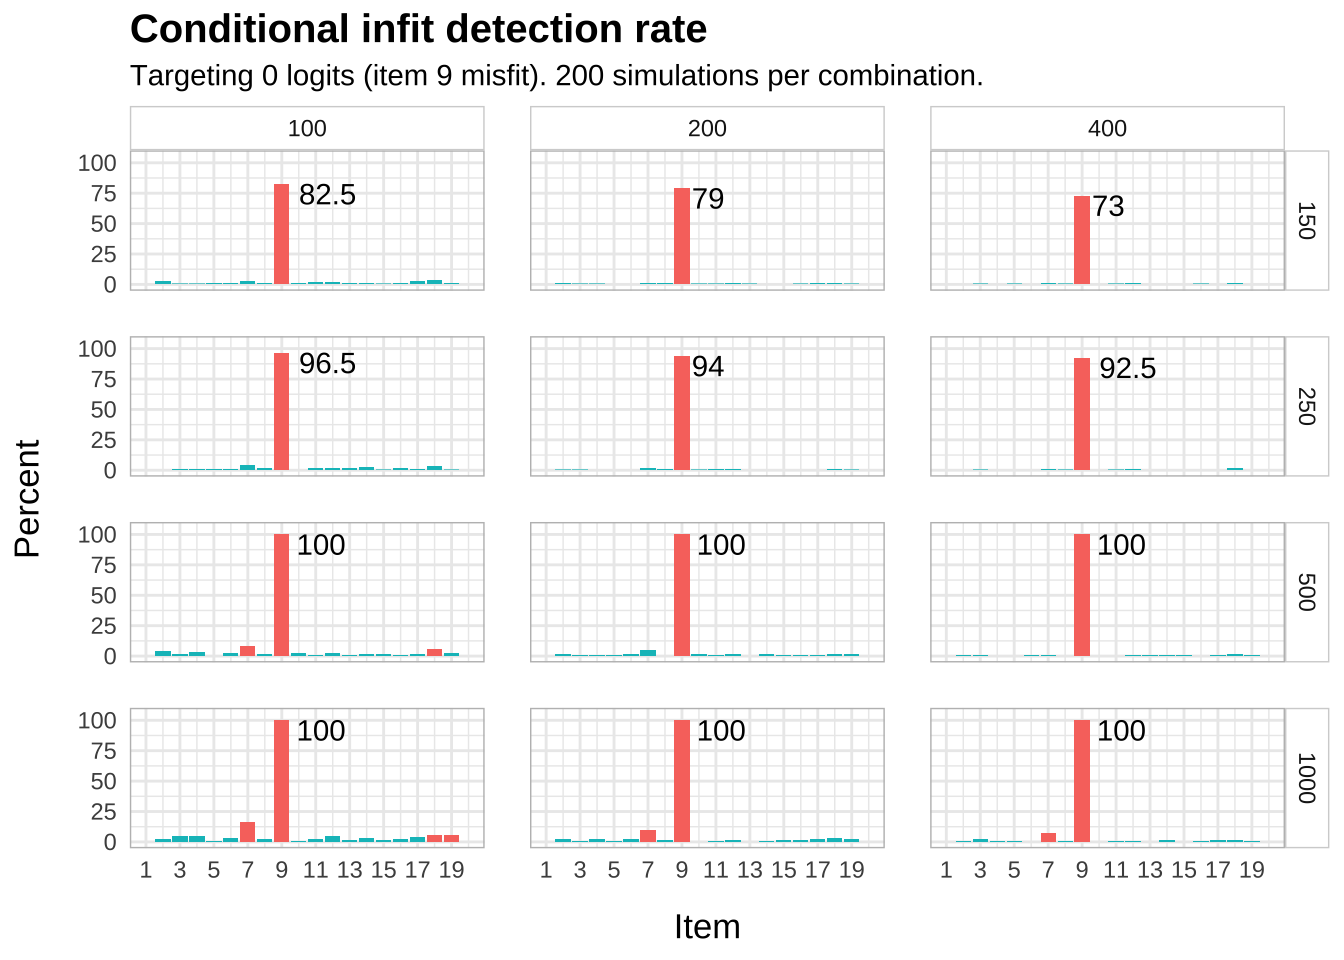

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

@fig-ifb0 shows the detection rate when the misfitting item is located at the sample mean. Detection rate is highest for the condition with 100 iterations with sample size 100 and 250, but it also shows higher levels of false positives when sample size increases to 500 or more.

(`geom_col()`).

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

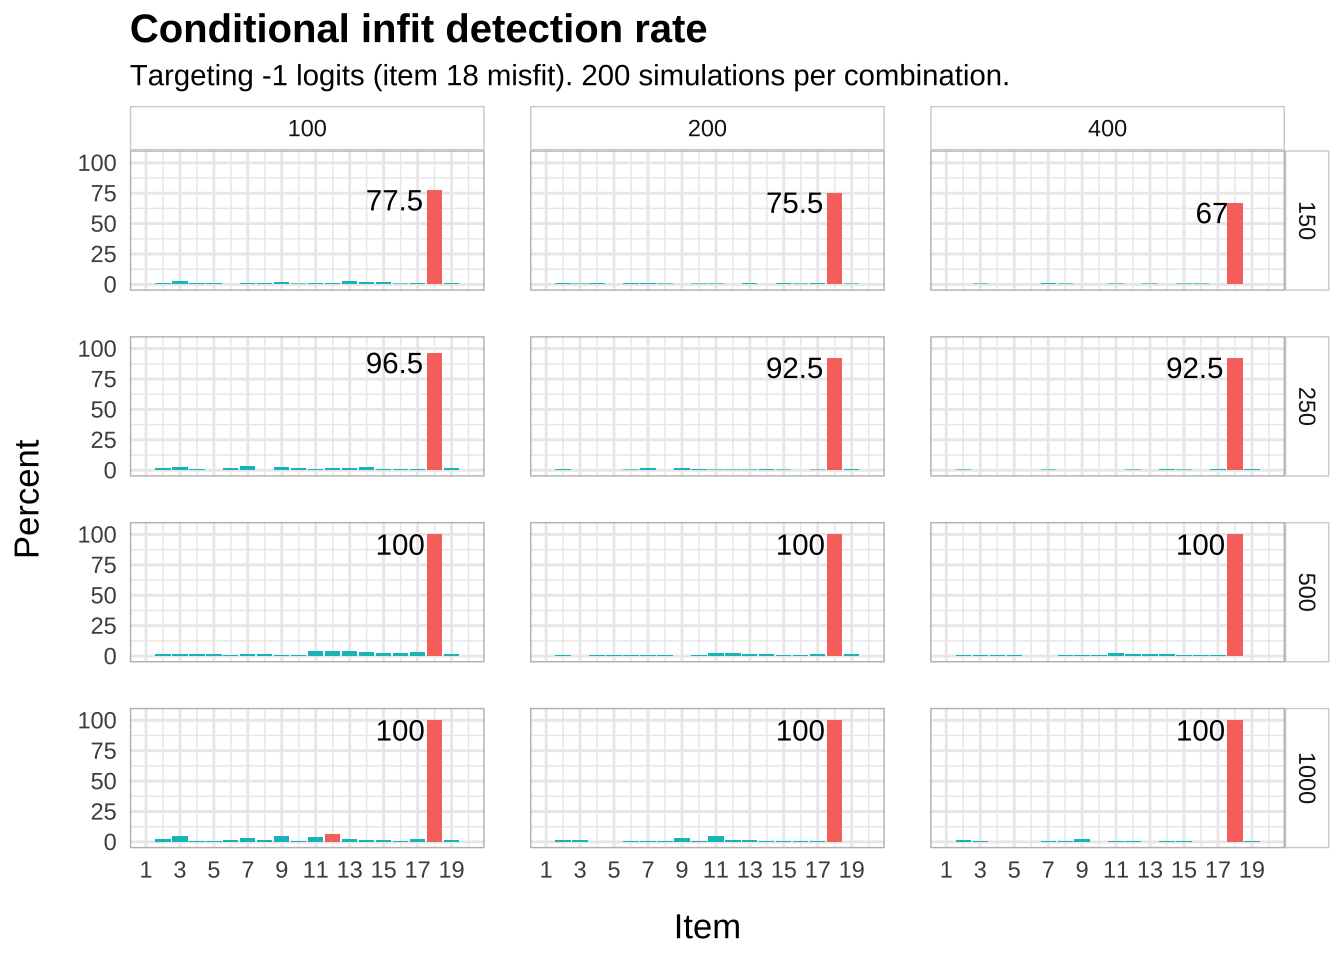

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

When the misfitting item is offset in targeting by -1 logits compared to the sample mean (see @fig-ifb1), the smallest sample size has less power to detect misfit compared to the on-target misfitting item. There are lower rates of false positives across all sample sizes and iterations.

(`geom_col()`).

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

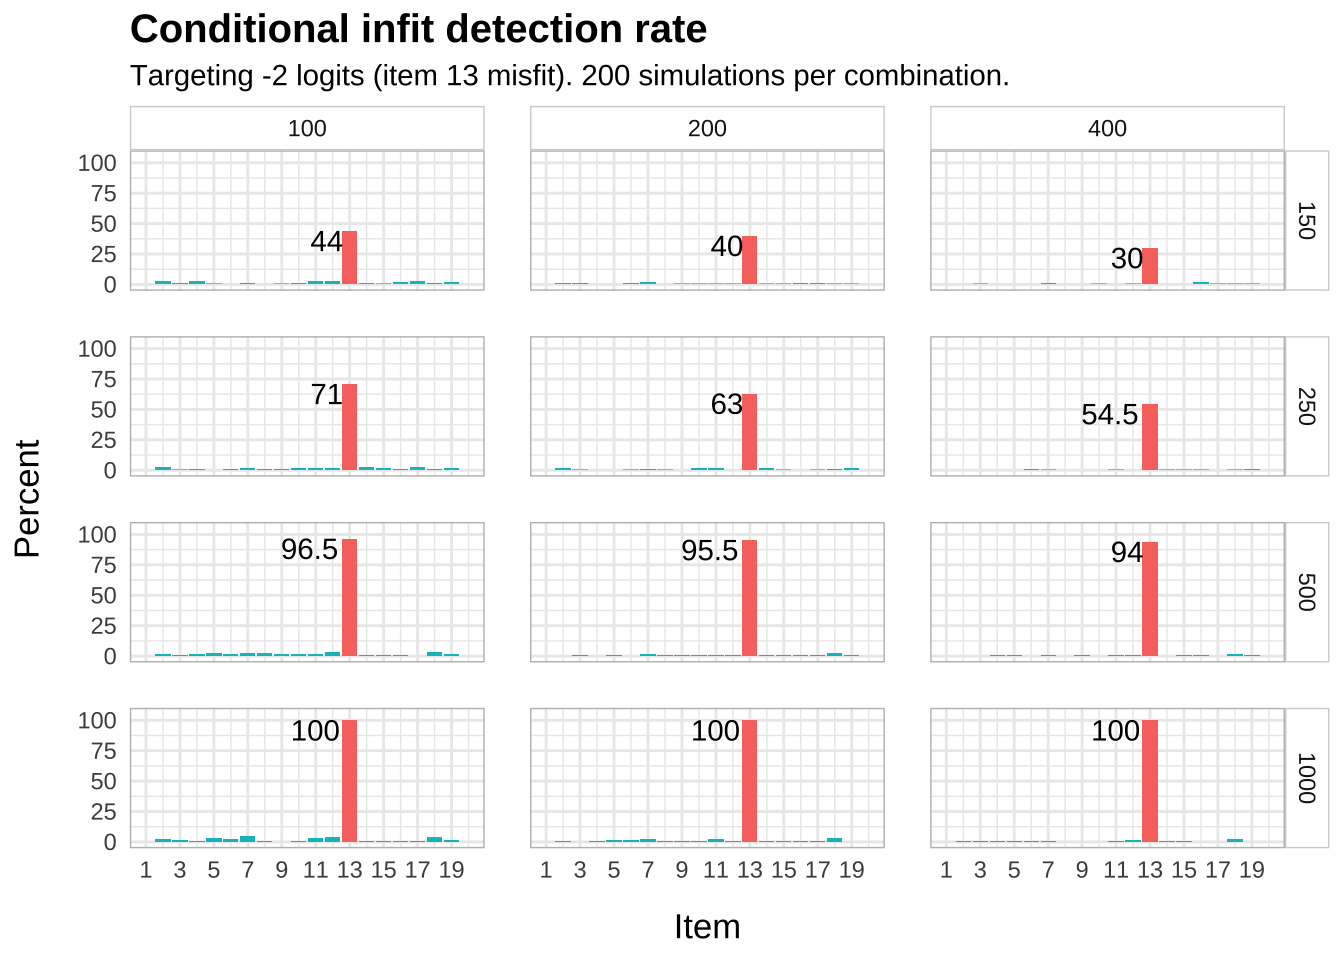

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

Finally, when the misfitting item is located at -2 logits compared to the sample mean (see @fig-ifb2), we see a stronger reduction in power for sample sizes 150 and 250. No false positives are identified.

### Outfit

(`geom_col()`).

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

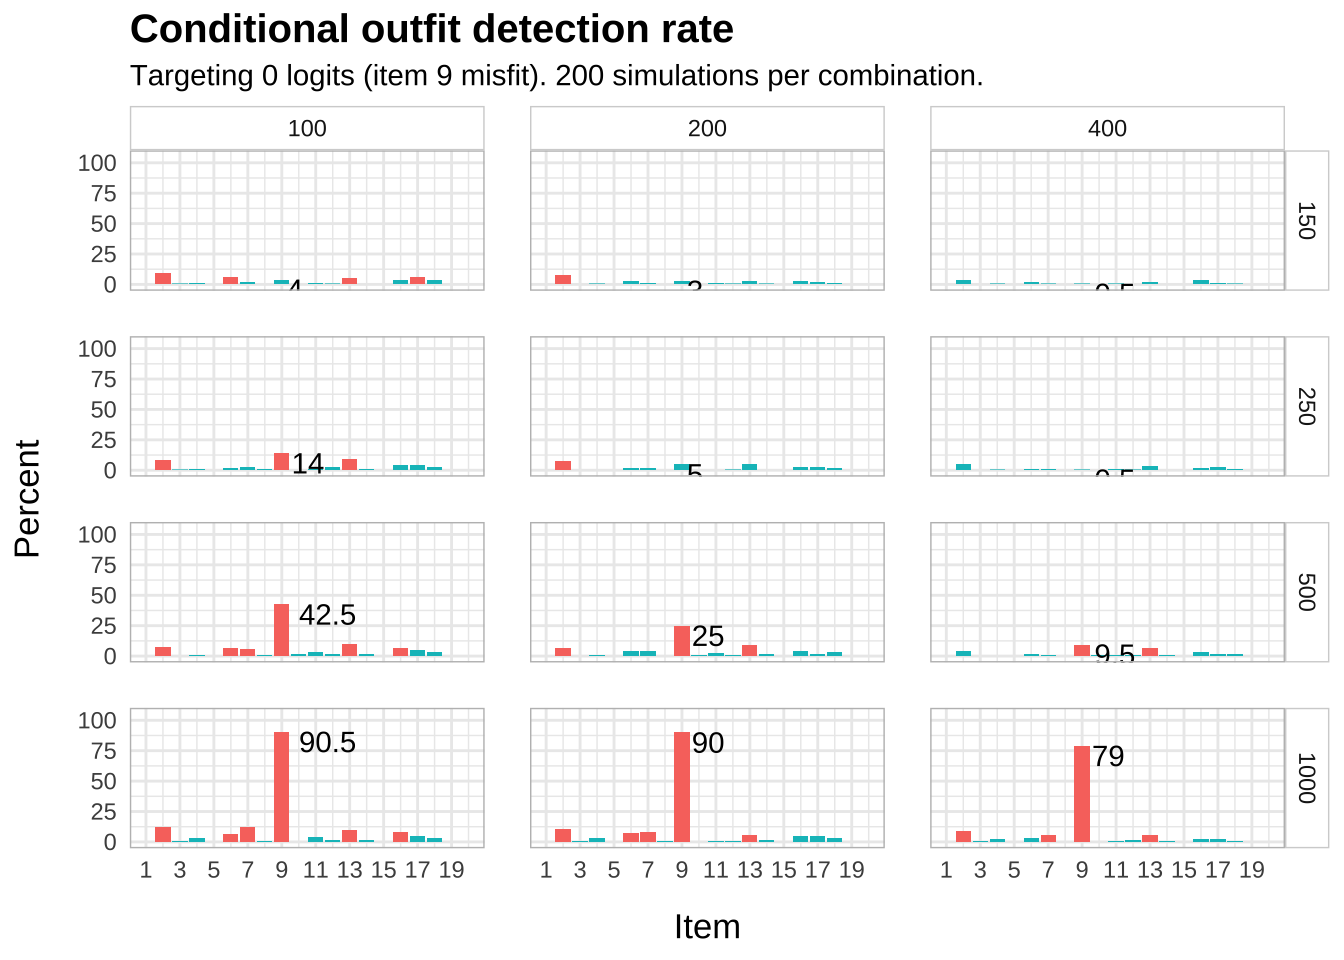

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

(`geom_col()`).

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

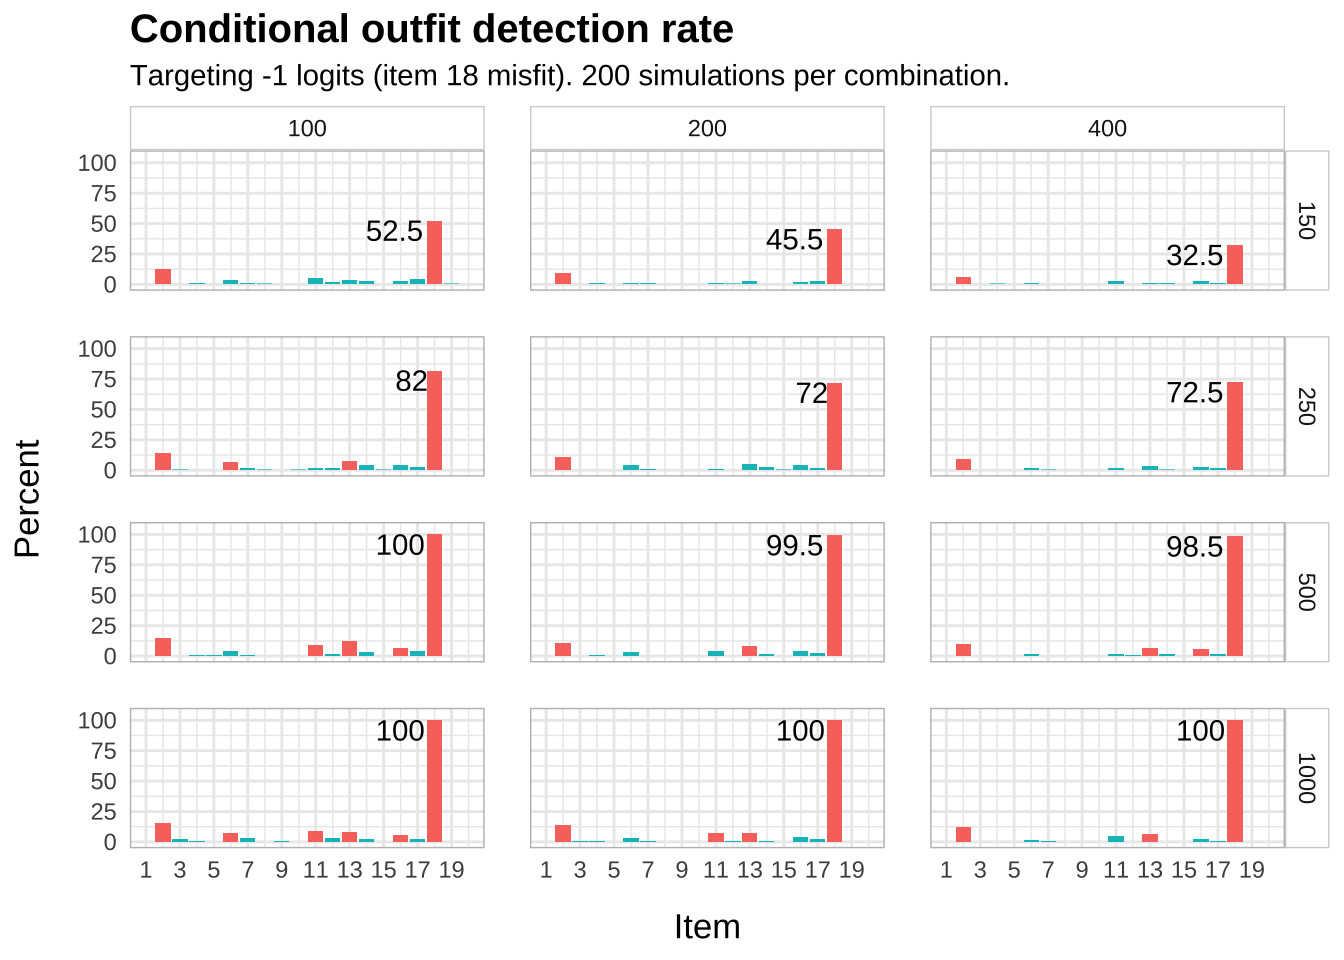

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

(`geom_col()`).

Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, will use 'sans' instead
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : font
family 'Lato' not found, 

Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font family 'Lato' not found, will use 'sans' instead
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
font f

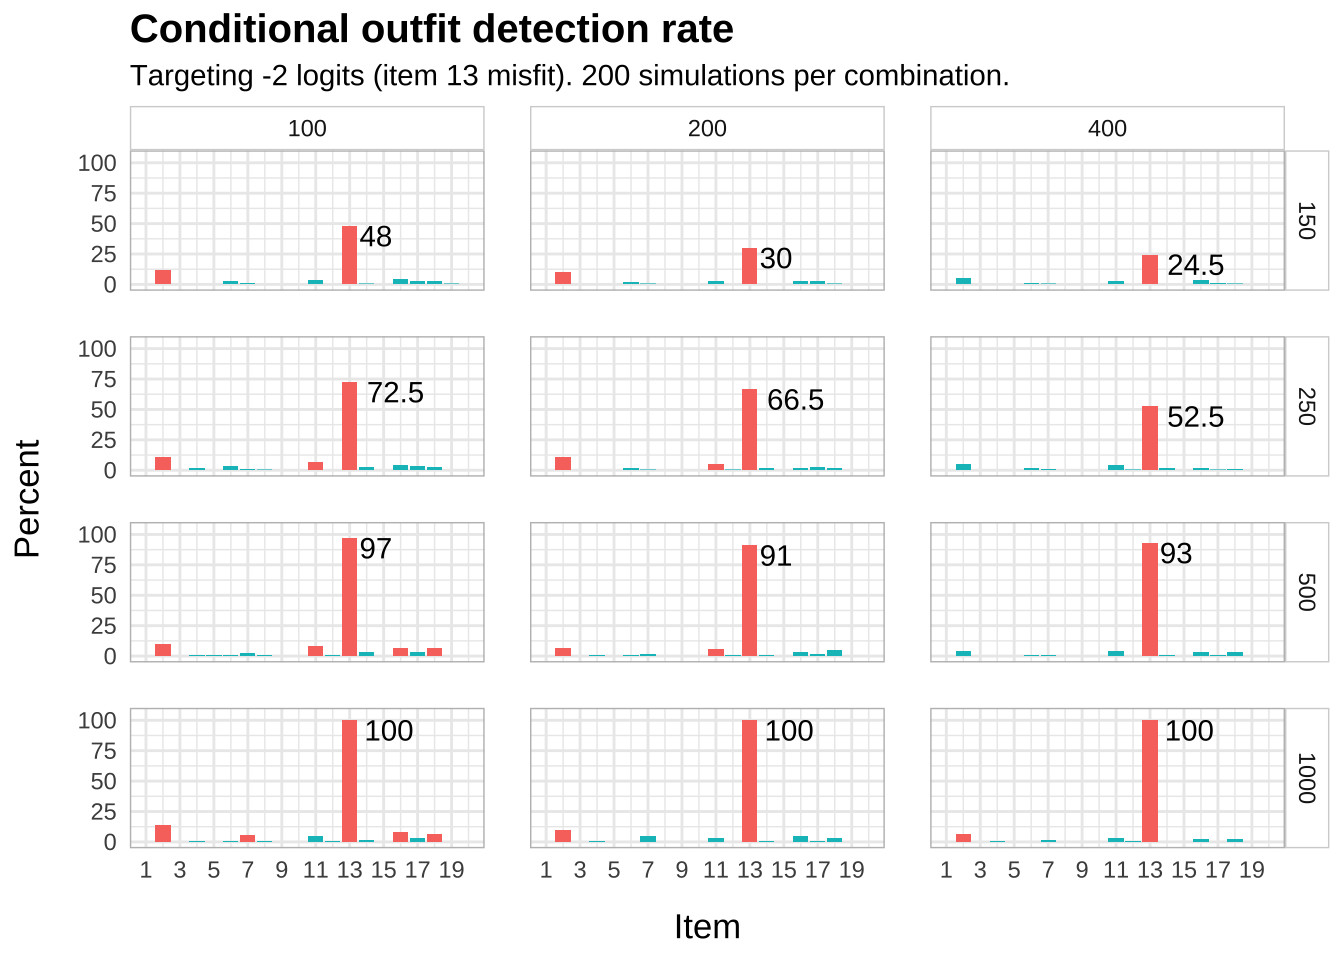

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,20), breaks = seq(1,20,2), guide = guide_axis(n.dodge = 1)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise() +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

As shown in @fig-ifb0out, @fig-ifb1out, and @fig-ifb2out, outfit is performing much worse than infit across the board.

### Comments

Based on these simulation, it seems reasonable to recommend the use of infit in determining item fit over outfit. The performance of outfit calls to question whether it is useful at all.

Regarding infit, it looks like 100 iterations are to recommend to determine cutoff values when the sample size is 250 or lower, while 200 or 400 iterations reduce the risk for false positives at sample sizes of 500 or larger. False positives are found at sample sizes 500 and 1000 only. The risk for false positives is notably higher when the misfitting item is located at the sample mean compared to when the misfitting item is off-target by -1 logits or more.

These findings make a good argument for removing one item at a time when the analysis indicates misfit, starting with the most misfitting item. This is especially relevant for sample sizes at 500 or above and when misfitting items are located close to the sample mean.

# Study 2

Item-restscore using the same datasets and adding the dataset with all three items misfitting.

# Study 3

Item-restscore bootstrapped to better handle big samples, but also perhaps for smaller samples?

# Discussion

# Conclusion

# References